In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv,
                                     inner, perturb_inv, clr, clr_inv, centralize)
from skbio.diversity.beta import weighted_unifrac
from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.ordination import ca, pcoa
from gneiss.util import rename_internal_nodes, match
from gneiss.sort import niche_sort, mean_niche_estimator
import scipy
import ternary
from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv, 
                                     inner, perturb_inv, clr, centralize)
from skbio.diversity.beta import weighted_unifrac
from skbio import TreeNode, DistanceMatrix

from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean
from biom import load_table
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
from collections import OrderedDict

from skbio.diversity import beta_diversity
from skbio.stats.distance import permanova
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def shift(l,n):
    sl = l
    table = [l]
    if n == 0:
        return table
    else:
        for k in range(n):
            sl = shift1(sl)
            table.append(sl)
        return table
def shift1(l):
    newlist = [0] * len(l)
    for i in range(1,len(l)):
        newlist[i] = l[i-1]
    return newlist

def band_statistic(table):
    n, m = table.shape
    sse = 0
    for x in range(table.shape[0]):
        for y in range(table.shape[1]):
            sse += ((y - (n/m) * x) * table[x, y]) **2
    return sse
    

In [3]:
n = 30  #otus 
band = 10 #band size
p = n - band + 1 #samples
y = [1./band]*band + [0]*(n-band)
table = shift(y,p-1)
table = np.column_stack(table)

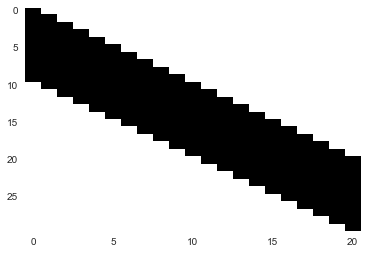

In [4]:
plt.imshow(table, aspect='auto', interpolation='nearest')
plt.grid(False)

In [5]:
band_statistic(table)

290.57142857142878

In [6]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [7]:
band_statistic(niche_sort(table_df, gradient_s).values)

290.57142857142878

Ok, let's try to see what this will look like for random data.

In [8]:
random_table = pd.DataFrame(np.random.uniform(low=0.0, high=2.0, size=table.shape))
random_ph = pd.Series(np.random.uniform(low=0.0, high=1.0, size=table.shape[1]))
random_sorted_table = niche_sort(random_table, random_ph)

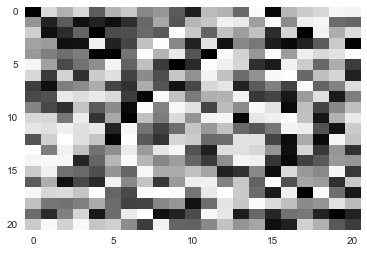

In [9]:
plt.imshow(random_sorted_table, aspect='auto', interpolation='nearest')
plt.grid(False)

In [10]:
band_statistic(random_table.values)

243714.98606534139

Ok, so it looks like our simple statistic isn't complete crap.
Let's now try to formalize a permutation test.

In [11]:
"""
Only permutes the pH
"""
def band_permutation_test1(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = band_statistic(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        _gradient = pd.Series(np.random.permutation(gradient_s),
                              index=gradient_s.index)
        _table = niche_sort(table, _gradient)
        sse_ = band_statistic(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse >= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [12]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [13]:
stat, pval, rstats = band_permutation_test1(table_df, gradient_s)

In [14]:
stat, pval

(290.57142857142878, 0.001)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


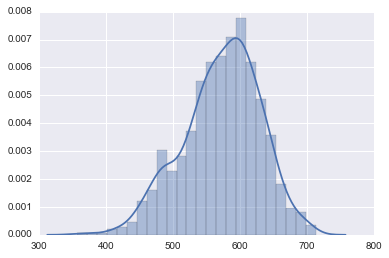

In [15]:
sns.distplot(rstats)

In [16]:
"""
Completely scrambles elements within the table.
"""
def band_permutation_test2(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = band_statistic(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        vals = np.random.permutation(table.values.flatten())
        _table = pd.DataFrame(vals.reshape(table.shape[0], table.shape[1]),
                              index=table.index, columns=table.columns)    
        _table = niche_sort(_table, gradient)
        sse_ = band_statistic(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse >= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [17]:
stat, pval, rstats = band_permutation_test2(table_df, gradient_s)

In [18]:
stat, pval

(290.57142857142878, 0.001)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


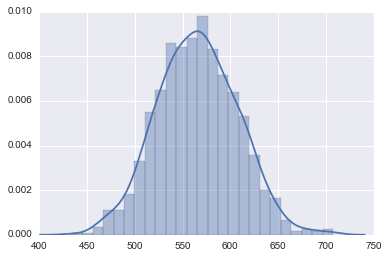

In [19]:
sns.distplot(rstats)